# 第39章: U-Netと位置エンコーディング

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] U-Netアーキテクチャを理解できる
- [ ] U-Netを実装できる
- [ ] 正弦波位置エンコーディングを理解できる
- [ ] タイムステップ情報をネットワークに組み込める

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Notebook 35（PyTorch基礎）
- ✅ Notebook 37-38（拡散モデル理論）
- ✅ 畳み込みニューラルネットワークの基礎

⏱️ **推定学習時間**: 150-180分  
📊 **難易度**: ★★★★☆（上級）  
🎓 **カテゴリ**: 実践

---

## 🌟 はじめに

拡散モデルでは、ノイズ予測ネットワーク $\epsilon_\theta(x_t, t)$ が中心的な役割を果たします。

### 🤔 なぜU-Netか？

1. **入出力が同じサイズ**: 入力画像と同じサイズのノイズを予測
2. **マルチスケール処理**: 大域的な構造と局所的な詳細の両方を捉える
3. **スキップ接続**: 情報の損失を防ぐ

### 📊 この章で実装するもの

1. **基本的な畳み込みブロック**
2. **ダウンサンプリング・アップサンプリング**
3. **正弦波位置エンコーディング**
4. **完全なU-Net**

In [88]:
# ============================================================
# 環境設定
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',
        'Yu Gothic', 'MS Gothic', 'Noto Sans CJK JP', 'IPAexGothic',
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"日本語フォント: {font_used}")

device = torch.device('cuda' if torch.cuda.is_available() else 
                      'mps' if torch.backends.mps.is_available() else 'cpu')

torch.manual_seed(42)
np.random.seed(42)

print(f"Device: {device}")
print("✅ ライブラリのインポート完了")

日本語フォント: Hiragino Sans
Device: mps
✅ ライブラリのインポート完了


---

## 1. U-Netアーキテクチャの概要

U-Netは元々医療画像セグメンテーションのために開発されましたが、拡散モデルでも広く使われています。

### 📊 U-Netの構造

```
入力 → [エンコーダ] → [ボトルネック] → [デコーダ] → 出力
         ↓               ↓                ↑
       Down            Middle            Up
       ↓↓↓              ↓               ↑↑↑
    ----------------スキップ接続-----------------
```

### 📊 主要コンポーネント

1. **エンコーダ（ダウンサンプリング）**: 解像度を下げながら特徴を抽出
2. **ボトルネック**: 最も低い解像度での処理
3. **デコーダ（アップサンプリング）**: 解像度を上げながら詳細を復元
4. **スキップ接続**: エンコーダからデコーダへ特徴を直接渡す

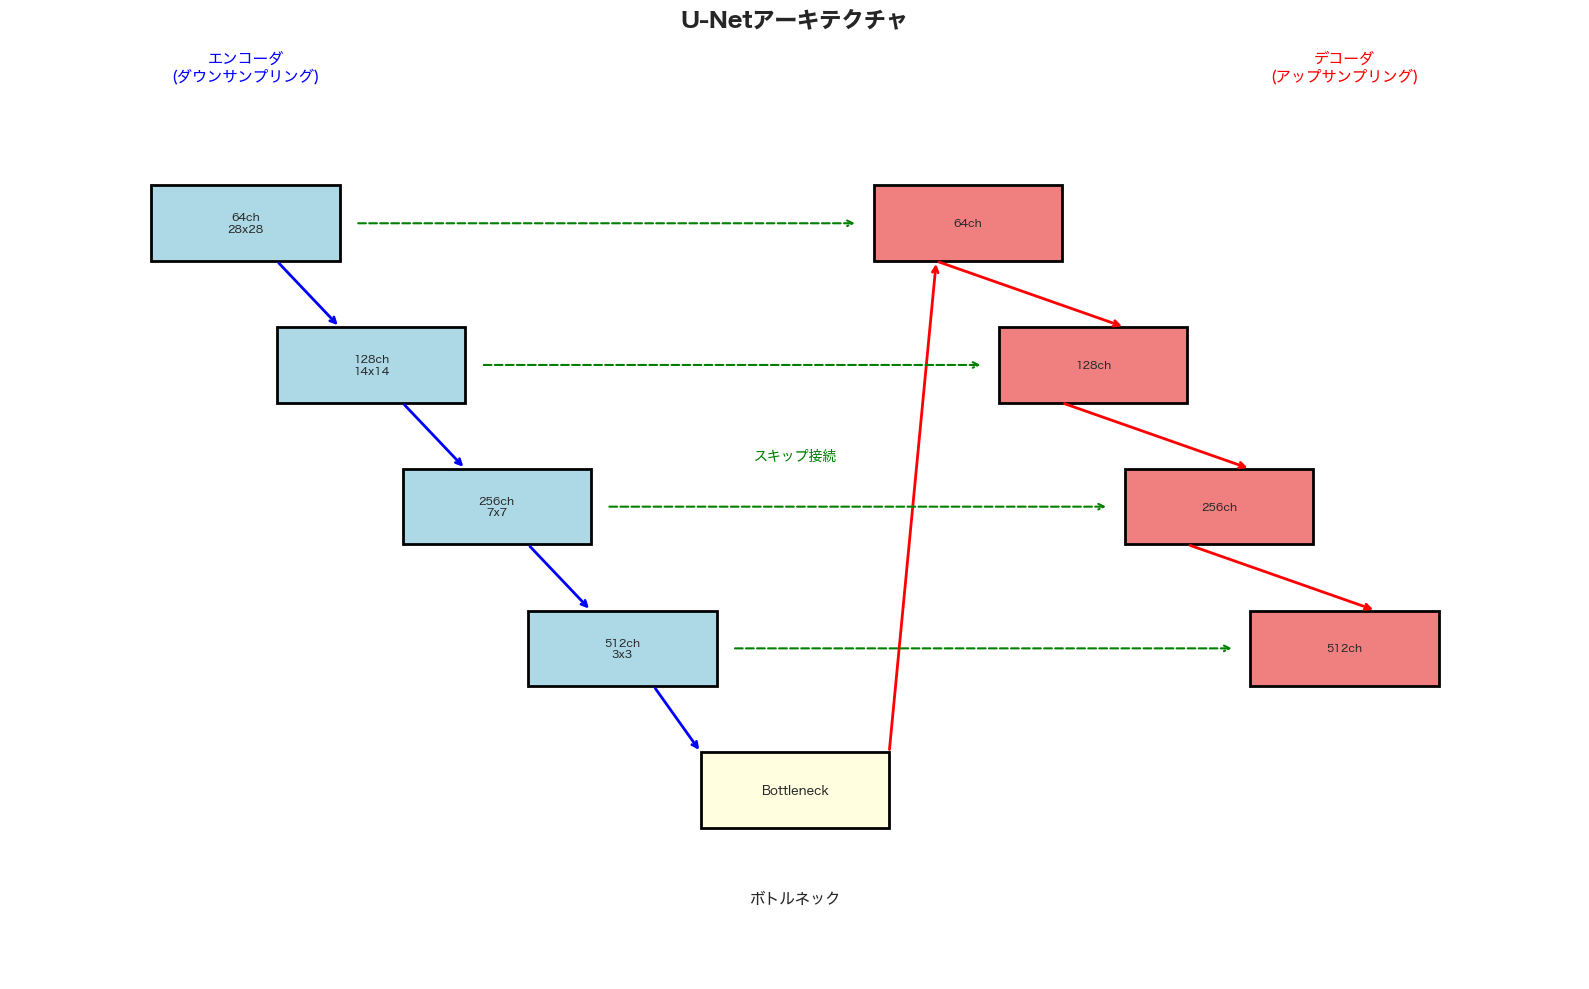

In [89]:
# ============================================================
# U-Netの構造を図示
# ============================================================

fig, ax = plt.subplots(figsize=(16, 10))

# U字型の構造を描画
levels = 4
box_width = 0.12
box_height = 0.08

# エンコーダ側
encoder_positions = []
for i in range(levels):
    x = 0.15 + i * 0.08
    y = 0.8 - i * 0.15
    encoder_positions.append((x, y))
    rect = plt.Rectangle((x - box_width/2, y - box_height/2), box_width, box_height,
                         facecolor='lightblue', edgecolor='black', lw=2)
    ax.add_patch(rect)
    ax.text(x, y, f'{64 * (2**i)}ch\n{28//(2**i)}x{28//(2**i)}', ha='center', va='center', fontsize=8)

# ボトルネック
x_bottom = 0.5
y_bottom = 0.2
rect = plt.Rectangle((x_bottom - box_width/2, y_bottom - box_height/2), box_width, box_height,
                     facecolor='lightyellow', edgecolor='black', lw=2)
ax.add_patch(rect)
ax.text(x_bottom, y_bottom, 'Bottleneck', ha='center', va='center', fontsize=9)

# デコーダ側
decoder_positions = []
for i in range(levels):
    x = 0.85 - i * 0.08
    y = 0.8 - (levels - 1 - i) * 0.15
    decoder_positions.append((x, y))
    rect = plt.Rectangle((x - box_width/2, y - box_height/2), box_width, box_height,
                         facecolor='lightcoral', edgecolor='black', lw=2)
    ax.add_patch(rect)
    ax.text(x, y, f'{64 * (2**(levels-1-i))}ch', ha='center', va='center', fontsize=8)

# ダウンサンプリング矢印
for i in range(levels - 1):
    ax.annotate('', xy=(encoder_positions[i+1][0] - 0.02, encoder_positions[i+1][1] + 0.04),
                xytext=(encoder_positions[i][0] + 0.02, encoder_positions[i][1] - 0.04),
                arrowprops=dict(arrowstyle='->', color='blue', lw=2))

# エンコーダからボトルネック
ax.annotate('', xy=(x_bottom - 0.06, y_bottom + 0.04),
            xytext=(encoder_positions[-1][0] + 0.02, encoder_positions[-1][1] - 0.04),
            arrowprops=dict(arrowstyle='->', color='blue', lw=2))

# ボトルネックからデコーダ
ax.annotate('', xy=(decoder_positions[-1][0] - 0.02, decoder_positions[-1][1] - 0.04),
            xytext=(x_bottom + 0.06, y_bottom + 0.04),
            arrowprops=dict(arrowstyle='->', color='red', lw=2))

# アップサンプリング矢印
for i in range(levels - 1):
    ax.annotate('', xy=(decoder_positions[i][0] + 0.02, decoder_positions[i][1] + 0.04),
                xytext=(decoder_positions[i+1][0] - 0.02, decoder_positions[i+1][1] - 0.04),
                arrowprops=dict(arrowstyle='->', color='red', lw=2))

# スキップ接続
for i in range(levels):
    ax.annotate('', xy=(decoder_positions[levels-1-i][0] - 0.07, decoder_positions[levels-1-i][1]),
                xytext=(encoder_positions[i][0] + 0.07, encoder_positions[i][1]),
                arrowprops=dict(arrowstyle='->', color='green', lw=1.5, ls='--'))

# ラベル
ax.text(0.15, 0.95, 'エンコーダ\n(ダウンサンプリング)', ha='center', fontsize=11, color='blue')
ax.text(0.85, 0.95, 'デコーダ\n(アップサンプリング)', ha='center', fontsize=11, color='red')
ax.text(0.5, 0.08, 'ボトルネック', ha='center', fontsize=11)
ax.text(0.5, 0.55, 'スキップ接続', ha='center', fontsize=10, color='green')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title('U-Netアーキテクチャ', fontsize=16, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

---

## 2. 基本的な畳み込みブロック

U-Netの基本単位は、畳み込み層 + 正規化 + 活性化関数のブロックです。

In [90]:
# ============================================================
# 基本的な畳み込みブロック
# ============================================================

class ConvBlock(nn.Module):
    """
    基本的な畳み込みブロック
    Conv -> GroupNorm -> SiLU -> Conv -> GroupNorm -> SiLU
    """
    
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(num_groups, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(num_groups, out_channels)
        self.activation = nn.SiLU()  # Swish activation
        
        # 残差接続用（チャンネル数が異なる場合）
        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.residual_conv = nn.Identity()
    
    def forward(self, x):
        residual = self.residual_conv(x)
        
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.activation(x)
        
        return x + residual

# テスト
block = ConvBlock(1, 64)
x = torch.randn(2, 1, 28, 28)
out = block(x)
print(f"入力: {x.shape}")
print(f"出力: {out.shape}")
print(f"パラメータ数: {sum(p.numel() for p in block.parameters()):,}")

入力: torch.Size([2, 1, 28, 28])
出力: torch.Size([2, 64, 28, 28])
パラメータ数: 37,952


---

## 3. 正弦波位置エンコーディング

### 🤔 なぜ位置エンコーディングが必要か？

拡散モデルでは、同じネットワークが異なるタイムステップ $t$ で使われます。ネットワークに「今どのタイムステップにいるか」を伝える必要があります。

### 📊 正弦波位置エンコーディング

Transformerで使われるのと同じ方式：

$$PE_{(t, 2i)} = \sin\left(\frac{t}{10000^{2i/d}}\right)$$
$$PE_{(t, 2i+1)} = \cos\left(\frac{t}{10000^{2i/d}}\right)$$

これにより、各タイムステップは一意のベクトルにエンコードされます。

In [91]:
# ============================================================
# 正弦波位置エンコーディングの実装
# ============================================================

class SinusoidalPositionEmbedding(nn.Module):
    """
    正弦波位置エンコーディング
    
    タイムステップ t を高次元ベクトルに変換
    """
    
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, t):
        """
        Parameters:
        -----------
        t : Tensor, shape (batch_size,)
            タイムステップ
        
        Returns:
        --------
        Tensor, shape (batch_size, dim)
            位置埋め込み
        """
        device = t.device
        half_dim = self.dim // 2
        
        # 周波数を計算
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        
        # t * 周波数
        embeddings = t[:, None] * embeddings[None, :]
        
        # sin と cos を交互に
        embeddings = torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)
        
        return embeddings

# テスト
pos_emb = SinusoidalPositionEmbedding(dim=128)
t = torch.tensor([0, 100, 500, 999], dtype=torch.float32)
emb = pos_emb(t)
print(f"タイムステップ: {t}")
print(f"埋め込みの形状: {emb.shape}")

タイムステップ: tensor([  0., 100., 500., 999.])
埋め込みの形状: torch.Size([4, 128])


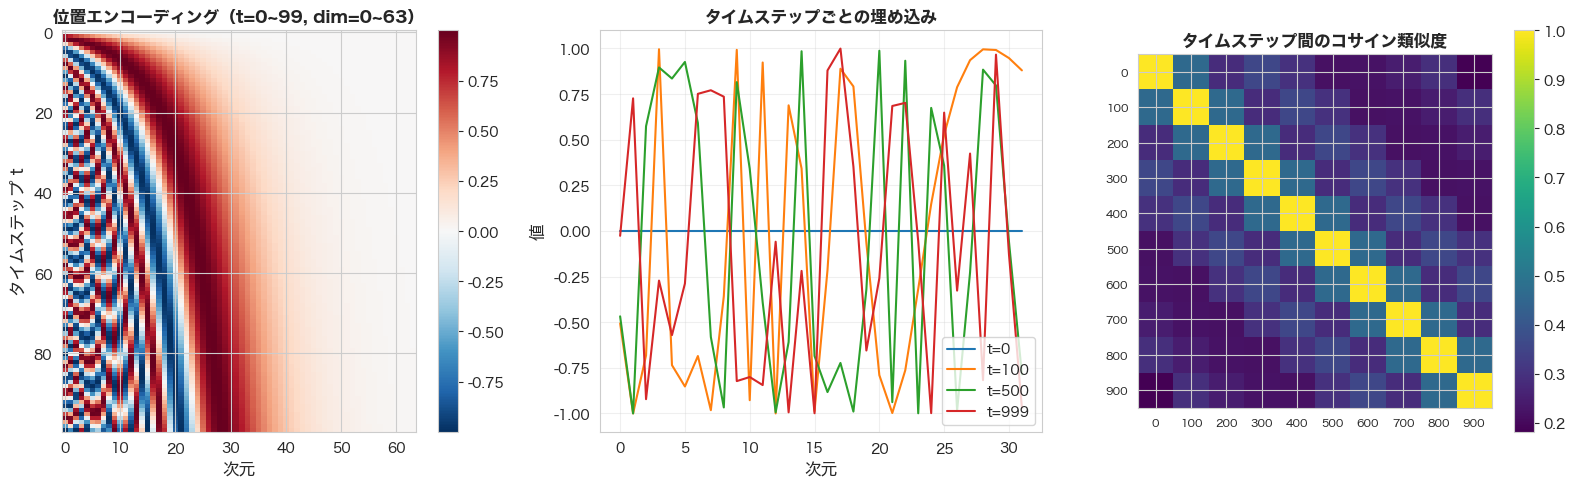

💡 観察:
  - 各タイムステップは一意の埋め込みを持つ
  - 近いタイムステップは類似した埋め込みを持つ
  - 低次元の周波数は遅く、高次元の周波数は速く変化する


In [92]:
# ============================================================
# 位置エンコーディングの可視化
# ============================================================

# 全タイムステップの埋め込みを計算
T = 1000
dim = 128
pos_emb = SinusoidalPositionEmbedding(dim=dim)
t_all = torch.arange(T, dtype=torch.float32)
embeddings = pos_emb(t_all)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 左: 埋め込みのヒートマップ
ax = axes[0]
im = ax.imshow(embeddings.numpy()[:100, :64], aspect='auto', cmap='RdBu_r')
ax.set_xlabel('次元', fontsize=12)
ax.set_ylabel('タイムステップ t', fontsize=12)
ax.set_title('位置エンコーディング（t=0~99, dim=0~63）', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax)

# 中央: いくつかのタイムステップの埋め込み
ax = axes[1]
for t_val in [0, 100, 500, 999]:
    ax.plot(embeddings[t_val, :32].numpy(), label=f't={t_val}')
ax.set_xlabel('次元', fontsize=12)
ax.set_ylabel('値', fontsize=12)
ax.set_title('タイムステップごとの埋め込み', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 右: 類似度（コサイン類似度）
ax = axes[2]
sample_t = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
sample_emb = embeddings[sample_t]
similarity = F.cosine_similarity(sample_emb.unsqueeze(0), sample_emb.unsqueeze(1), dim=2)
im = ax.imshow(similarity.numpy(), cmap='viridis')
ax.set_xticks(range(len(sample_t)))
ax.set_yticks(range(len(sample_t)))
ax.set_xticklabels(sample_t, fontsize=8)
ax.set_yticklabels(sample_t, fontsize=8)
ax.set_title('タイムステップ間のコサイン類似度', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

print("💡 観察:")
print("  - 各タイムステップは一意の埋め込みを持つ")
print("  - 近いタイムステップは類似した埋め込みを持つ")
print("  - 低次元の周波数は遅く、高次元の周波数は速く変化する")

---

## 4. タイムステップ埋め込みの注入

タイムステップの埋め込みを畳み込みブロックに注入する方法はいくつかあります：

1. **加算**: 特徴マップに埋め込みを加算
2. **スケーリング**: 特徴マップを埋め込みでスケール
3. **AdaGN（Adaptive Group Normalization）**: 正規化のパラメータを条件付け

In [93]:
# ============================================================
# タイムステップ条件付き畳み込みブロック
# ============================================================

class TimeConditionedConvBlock(nn.Module):
    """
    タイムステップ条件付きの畳み込みブロック
    
    タイムステップ埋め込みを特徴マップに加算して注入
    """
    
    def __init__(self, in_channels, out_channels, time_dim, num_groups=8):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(num_groups, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(num_groups, out_channels)
        self.activation = nn.SiLU()
        
        # タイムステップ埋め込みの射影
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_dim, out_channels),
        )
        
        # 残差接続
        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.residual_conv = nn.Identity()
    
    def forward(self, x, t_emb):
        """
        Parameters:
        -----------
        x : Tensor, shape (B, C, H, W)
            入力特徴マップ
        t_emb : Tensor, shape (B, time_dim)
            タイムステップ埋め込み
        """
        residual = self.residual_conv(x)
        
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.activation(x)
        
        # タイムステップ埋め込みを注入
        t_emb = self.time_mlp(t_emb)  # (B, out_channels)
        t_emb = t_emb[:, :, None, None]  # (B, out_channels, 1, 1)
        x = x + t_emb  # ブロードキャスト加算
        
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.activation(x)
        
        return x + residual

# テスト
block = TimeConditionedConvBlock(1, 64, time_dim=128)
x = torch.randn(2, 1, 28, 28)
t_emb = torch.randn(2, 128)
out = block(x, t_emb)
print(f"入力 x: {x.shape}")
print(f"タイムステップ埋め込み: {t_emb.shape}")
print(f"出力: {out.shape}")

入力 x: torch.Size([2, 1, 28, 28])
タイムステップ埋め込み: torch.Size([2, 128])
出力: torch.Size([2, 64, 28, 28])


---

## 5. ダウンサンプリングとアップサンプリング

In [94]:
# ============================================================
# ダウンサンプリング・アップサンプリング
# ============================================================

class Downsample(nn.Module):
    """ダウンサンプリング（解像度を半分に）"""
    
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
    
    def forward(self, x):
        return self.conv(x)


class Upsample(nn.Module):
    """アップサンプリング（解像度を2倍に）"""
    
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)

# テスト
x = torch.randn(2, 64, 28, 28)

down = Downsample(64)
x_down = down(x)
print(f"ダウンサンプリング: {x.shape} -> {x_down.shape}")

up = Upsample(64)
x_up = up(x_down)
print(f"アップサンプリング: {x_down.shape} -> {x_up.shape}")

ダウンサンプリング: torch.Size([2, 64, 28, 28]) -> torch.Size([2, 64, 14, 14])
アップサンプリング: torch.Size([2, 64, 14, 14]) -> torch.Size([2, 64, 28, 28])


---

## 6. 完全なU-Netの実装

以上のコンポーネントを組み合わせて、拡散モデル用の完全なU-Netを実装します。

In [95]:
# ============================================================
# 完全なU-Net
# ============================================================

class SimpleUNet(nn.Module):
    """
    拡散モデル用のシンプルなU-Net
    
    MNIST (28x28) 用に設計
    """
    
    def __init__(self, in_channels=1, out_channels=1, time_dim=128, 
                 base_channels=64, channel_mults=(1, 2, 4)):
        super().__init__()
        
        self.time_dim = time_dim
        
        # タイムステップ埋め込み
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbedding(time_dim),
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim),
        )
        
        # 初期畳み込み
        self.init_conv = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1)
        
        # エンコーダ
        self.down_blocks = nn.ModuleList()
        self.down_samples = nn.ModuleList()
        
        channels = [base_channels * m for m in channel_mults]
        in_ch = base_channels
        
        for i, out_ch in enumerate(channels):
            self.down_blocks.append(
                TimeConditionedConvBlock(in_ch, out_ch, time_dim)
            )
            if i < len(channels) - 1:
                self.down_samples.append(Downsample(out_ch))
            in_ch = out_ch
        
        # ボトルネック
        self.mid_block = TimeConditionedConvBlock(channels[-1], channels[-1], time_dim)
        
        # デコーダ
        self.up_samples = nn.ModuleList()
        self.up_blocks = nn.ModuleList()

        reversed_channels = list(reversed(channels))

        for i, out_ch in enumerate(reversed_channels):
            if i == 0:
                # 最初のブロック：ボトルネックからの入力のみ
                in_ch = reversed_channels[0]
            else:
                # 前のブロックの出力 + スキップ接続
                in_ch = reversed_channels[i-1] + channels[len(channels)-1-i]
            if i > 0:
                self.up_samples.append(Upsample(reversed_channels[i-1]))
            self.up_blocks.append(
                TimeConditionedConvBlock(in_ch, out_ch, time_dim)
            )
        
        # 最終畳み込み
        self.final_conv = nn.Sequential(
            nn.GroupNorm(8, base_channels),
            nn.SiLU(),
            nn.Conv2d(base_channels, out_channels, kernel_size=3, padding=1),
        )
    
    def forward(self, x, t):
        """
        Parameters:
        -----------
        x : Tensor, shape (B, C, H, W)
            ノイズが加えられた画像
        t : Tensor, shape (B,)
            タイムステップ
        
        Returns:
        --------
        Tensor, shape (B, C, H, W)
            予測されたノイズ
        """
        # タイムステップ埋め込み
        t_emb = self.time_embed(t.float())
        
        # 初期畳み込み
        x = self.init_conv(x)
        
        # エンコーダ（ダウンサンプリング）
        skip_connections = []
        for i, block in enumerate(self.down_blocks):
            x = block(x, t_emb)
            skip_connections.append(x)
            if i < len(self.down_samples):
                x = self.down_samples[i](x)
        
        # ボトルネック
        x = self.mid_block(x, t_emb)
        
        # デコーダ（アップサンプリング）
        for i, block in enumerate(self.up_blocks):
            if i > 0:
                x = self.up_samples[i-1](x)
                # スキップ接続
                skip = skip_connections[-(i+1)]
                x = torch.cat([x, skip], dim=1)
            x = block(x, t_emb)
        
        # 最終畳み込み
        return self.final_conv(x)

# テスト
model = SimpleUNet(in_channels=1, out_channels=1)
x = torch.randn(2, 1, 28, 28)
t = torch.randint(0, 1000, (2,))
out = model(x, t)

print(f"入力 x: {x.shape}")
print(f"タイムステップ t: {t}")
print(f"出力: {out.shape}")
print(f"\n総パラメータ数: {sum(p.numel() for p in model.parameters()):,}")

入力 x: torch.Size([2, 1, 28, 28])
タイムステップ t: tensor([810, 169])
出力: torch.Size([2, 1, 28, 28])

総パラメータ数: 5,589,953


In [96]:
# ============================================================
# モデルの構造を確認
# ============================================================

print("="*60)
print("SimpleUNet の構造")
print("="*60)

for name, module in model.named_children():
    if isinstance(module, nn.ModuleList):
        print(f"\n{name}:")
        for i, sub_module in enumerate(module):
            print(f"  [{i}] {sub_module.__class__.__name__}")
    else:
        print(f"\n{name}: {module.__class__.__name__}")

SimpleUNet の構造

time_embed: Sequential

init_conv: Conv2d

down_blocks:
  [0] TimeConditionedConvBlock
  [1] TimeConditionedConvBlock
  [2] TimeConditionedConvBlock

down_samples:
  [0] Downsample
  [1] Downsample

mid_block: TimeConditionedConvBlock

up_samples:
  [0] Upsample
  [1] Upsample

up_blocks:
  [0] TimeConditionedConvBlock
  [1] TimeConditionedConvBlock
  [2] TimeConditionedConvBlock

final_conv: Sequential


---

## 7. U-Netの動作確認

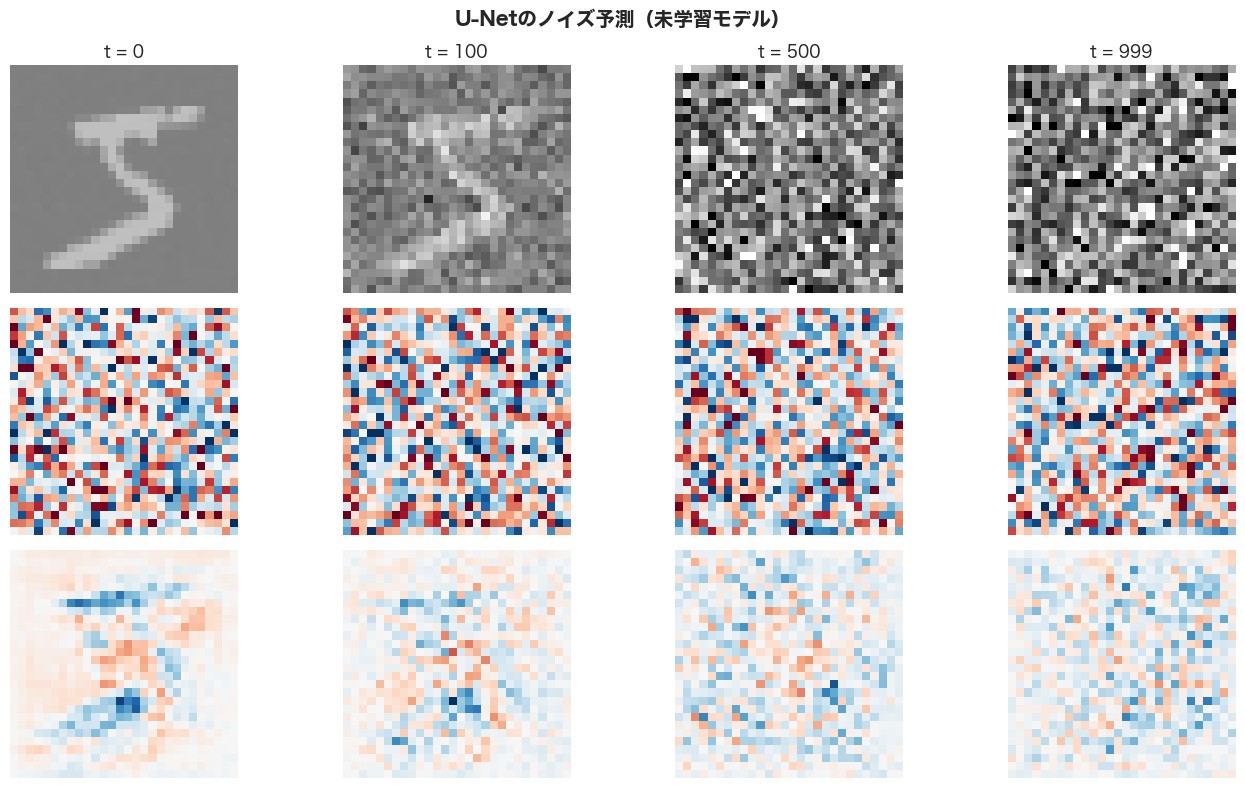

💡 未学習なので予測はランダムですが、入力と同じサイズの出力が得られます


In [97]:
# ============================================================
# 異なるタイムステップでの出力を確認
# ============================================================

# MNISTデータを読み込み
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
sample_image = mnist.data[0].float().unsqueeze(0).unsqueeze(0) / 255.0

# ノイズスケジュール
T = 1000
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

# モデル（未学習）
model = SimpleUNet(in_channels=1, out_channels=1).to(device)

# 異なるタイムステップでテスト
test_timesteps = [0, 100, 500, 999]

fig, axes = plt.subplots(3, len(test_timesteps), figsize=(14, 8))

for idx, t in enumerate(test_timesteps):
    # ノイズを追加
    noise = torch.randn_like(sample_image)
    alpha_bar_t = alpha_bars[t]
    x_t = torch.sqrt(alpha_bar_t) * sample_image + torch.sqrt(1 - alpha_bar_t) * noise
    
    # ノイズを予測
    x_t_device = x_t.to(device)
    t_tensor = torch.tensor([t]).to(device)
    
    with torch.no_grad():
        noise_pred = model(x_t_device, t_tensor)
    
    # 可視化
    axes[0, idx].imshow(x_t.squeeze().numpy(), cmap='gray', vmin=-2, vmax=2)
    axes[0, idx].set_title(f't = {t}', fontsize=12)
    axes[0, idx].axis('off')
    if idx == 0:
        axes[0, idx].set_ylabel('入力 x_t', fontsize=11)
    
    axes[1, idx].imshow(noise.squeeze().numpy(), cmap='RdBu_r', vmin=-2, vmax=2)
    axes[1, idx].axis('off')
    if idx == 0:
        axes[1, idx].set_ylabel('真のノイズ ε', fontsize=11)
    
    axes[2, idx].imshow(noise_pred.squeeze().cpu().numpy(), cmap='RdBu_r', vmin=-2, vmax=2)
    axes[2, idx].axis('off')
    if idx == 0:
        axes[2, idx].set_ylabel('予測 ε_θ', fontsize=11)

plt.suptitle('U-Netのノイズ予測（未学習モデル）', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 未学習なので予測はランダムですが、入力と同じサイズの出力が得られます")

---

## 8. 訓練の準備

In [98]:
# ============================================================
# 訓練用の関数を定義
# ============================================================

def get_loss(model, x_0, t, betas, alpha_bars, device):
    """
    拡散モデルの損失を計算
    
    L = ||ε - ε_θ(x_t, t)||²
    """
    # ノイズをサンプル
    noise = torch.randn_like(x_0).to(device)
    
    # x_t を計算（t.cpu()でインデックスアクセス、その後deviceに移動）
    alpha_bar_t = alpha_bars[t.cpu()].view(-1, 1, 1, 1).to(device)
    x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
    
    # ノイズを予測
    noise_pred = model(x_t, t)
    
    # 損失を計算
    loss = F.mse_loss(noise_pred, noise)
    
    return loss


def train_step(model, optimizer, dataloader, betas, alpha_bars, device, T=1000):
    """
    1エポックの訓練
    """
    model.train()
    total_loss = 0
    
    for batch_idx, (x_0, _) in enumerate(dataloader):
        x_0 = x_0.to(device)
        batch_size = x_0.shape[0]
        
        # ランダムなタイムステップ
        t = torch.randint(0, T, (batch_size,)).to(device)
        
        # 損失を計算
        loss = get_loss(model, x_0, t, betas, alpha_bars, device)
        
        # 最適化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

print("✅ 訓練用関数を定義しました")

✅ 訓練用関数を定義しました


In [99]:
# ============================================================
# 短い訓練テスト
# ============================================================

# データローダー
train_loader = DataLoader(mnist, batch_size=64, shuffle=True)

# モデルとオプティマイザ
model = SimpleUNet(in_channels=1, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ノイズスケジュール
T = 1000
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

print("短い訓練テスト（2エポック）...")

for epoch in range(2):
    loss = train_step(model, optimizer, train_loader, betas, alpha_bars, device, T)
    print(f"  Epoch {epoch+1}: Loss = {loss:.4f}")

print("\n✅ 訓練が正常に動作することを確認しました")

短い訓練テスト（2エポック）...
  Epoch 1: Loss = 0.0444
  Epoch 2: Loss = 0.0219

✅ 訓練が正常に動作することを確認しました


---

## まとめ

### 🎯 このノートブックで学んだこと

**U-Netアーキテクチャ**
- ✓ エンコーダ・デコーダ構造
- ✓ スキップ接続の重要性
- ✓ ダウンサンプリング・アップサンプリング

**正弦波位置エンコーディング**
- ✓ タイムステップの埋め込み
- ✓ sin/cos による位置表現
- ✓ 畳み込みブロックへの注入方法

**実装**
- ✓ `ConvBlock`: 基本畳み込みブロック
- ✓ `TimeConditionedConvBlock`: タイムステップ条件付きブロック
- ✓ `SimpleUNet`: 完全なU-Net

### 📊 コンポーネントのまとめ

| コンポーネント | 役割 |
|--------------|------|
| `SinusoidalPositionEmbedding` | t → 埋め込みベクトル |
| `ConvBlock` | Conv + Norm + Activation |
| `TimeConditionedConvBlock` | ConvBlock + 時間条件 |
| `Downsample` | 解像度を半分に |
| `Upsample` | 解像度を2倍に |
| `SimpleUNet` | 完全なノイズ予測器 |

---

## 🎓 自己評価クイズ

### Q1: U-Netのスキップ接続の役割は何ですか？

<details>
<summary>💡 答えを見る</summary>

**答え**:
- エンコーダからデコーダへ詳細な特徴を直接渡す
- ダウンサンプリングで失われる情報を補う
- 勾配消失問題を軽減
- 高解像度の詳細と低解像度の意味的情報を組み合わせる

</details>

---

### Q2: 正弦波位置エンコーディングの利点は何ですか？

<details>
<summary>💡 答えを見る</summary>

**答え**:
- 各タイムステップに一意の表現を与える
- 近いタイムステップは類似した埋め込みを持つ
- 訓練中に見ていないタイムステップにも一般化可能
- 学習パラメータがない（計算が軽い）

</details>

---

### Q3: タイムステップ埋め込みはどのように畳み込みブロックに注入されますか？

<details>
<summary>💡 答えを見る</summary>

**答え**:
1. タイムステップ t を位置エンコーディングで埋め込みベクトルに変換
2. MLPで特徴マップのチャンネル数に射影
3. 特徴マップに加算（ブロードキャスト）
4. または、AdaGN（Adaptive Group Normalization）で正規化パラメータを条件付け

</details>

---

### ✅ 学習チェックリスト

- [ ] U-Netの構造を説明できる
- [ ] 正弦波位置エンコーディングを実装できる
- [ ] タイムステップ条件付きブロックを実装できる
- [ ] 完全なU-Netを組み立てられる

---

**次のステップ**: Notebook 40で、**拡散モデルの実装（基礎編）**を完成させます！

U-Netを使って実際にMNISTで拡散モデルを訓練し、画像を生成します。